In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize


Classification problem on a new small dataset with KNN classifier

# Import and prepare data

In [77]:
df = pd.read_csv("drug200.csv")
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Preprocessing
Convert everything to integers

In [78]:
sex_renames = {"M": 0,
               "F": 1}
df["Sex"] = df["Sex"].map(sex_renames)

In [79]:
bp_renames = {"LOW": 0,
              "NORMAL": 1,
              "HIGH": 2}
df["BP"] = df["BP"].map(bp_renames)

In [80]:
cholesterol_rename = {"NORMAL": 0,
                      "HIGH": 1}
df["Cholesterol"] = df["Cholesterol"].map(bp_renames)

In [81]:
le = LabelEncoder()
df['Drug'] = le.fit_transform(df['Drug'])

In [82]:
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,2,2,25.355,0
1,47,0,0,2,13.093,3
2,47,0,0,2,10.114,3
3,28,1,1,2,7.798,4
4,61,1,0,2,18.043,0
...,...,...,...,...,...,...
195,56,1,0,2,11.567,3
196,16,0,0,2,12.006,3
197,52,0,1,2,9.894,4
198,23,0,1,1,14.020,4


In [83]:
df.Drug.value_counts()

0    91
4    54
1    23
3    16
2    16
Name: Drug, dtype: int64

Quite imbalance, but we'll see how KNN manage

## Analysis

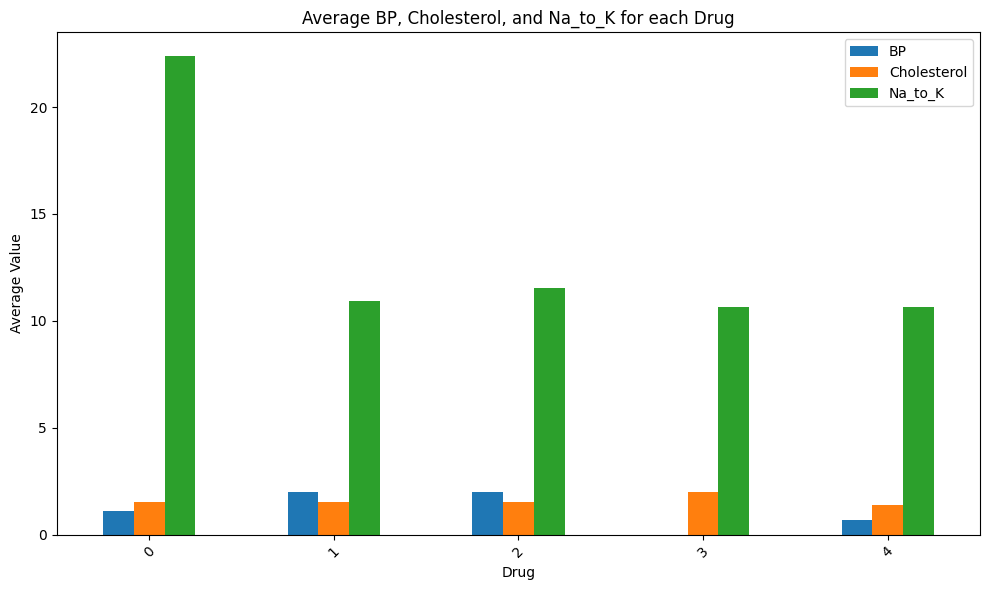

In [84]:
# Group by Drug and compute the mean of selected columns
grouped = df.groupby('Drug')[['BP', 'Cholesterol', 'Na_to_K']].mean()
grouped.plot(kind='bar', figsize=(10, 6))
plt.title("Average BP, Cholesterol, and Na_to_K for each Drug")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

So, people taking first group of drugs have clearly high Na to K proportions. 

Group number three clearly low blood pressure.

Number four normal blood pressure, normal cholesterol and average Na to K proportions.

I guesss there might be the problem with distinguishing groups 1 and 2 as they look pretty similar.

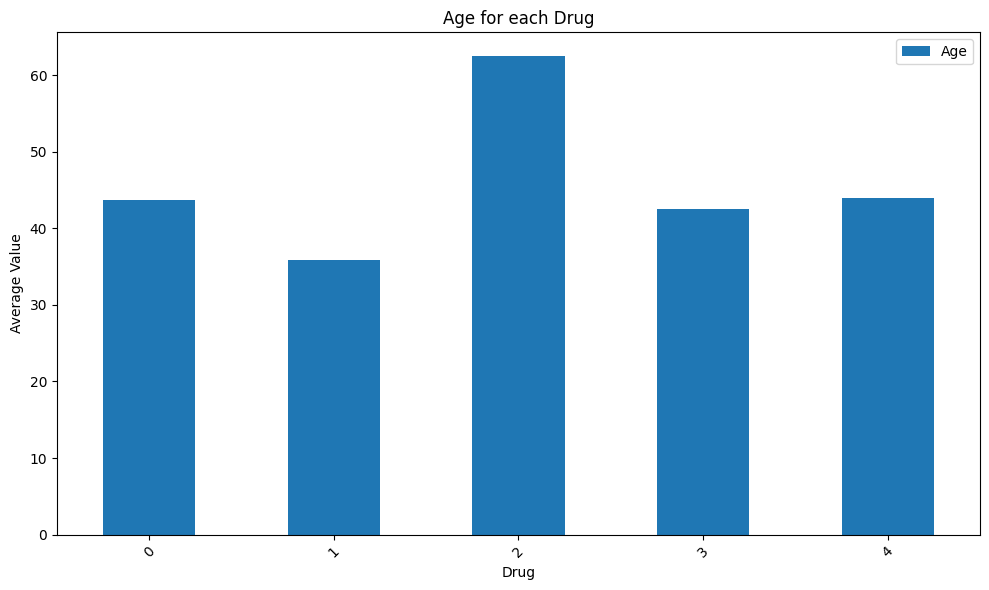

In [85]:
# Group by Drug and compute the mean of selected columns
age = df.groupby('Drug')[["Age"]].mean()
age.plot(kind='bar', figsize=(10, 6))
plt.title("Age for each Drug")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

However, group 1 is younger that 2, that my help

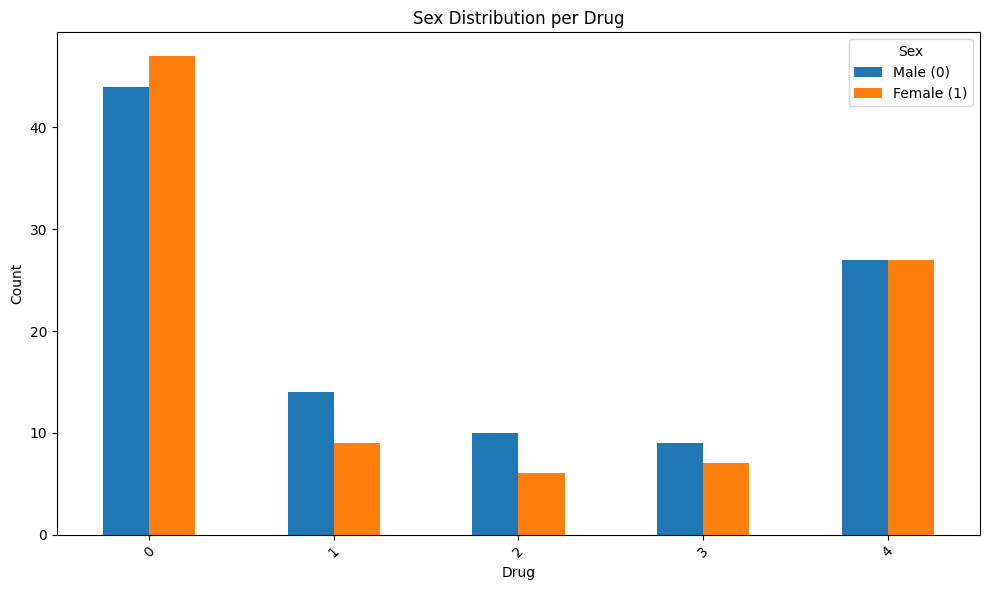

In [86]:
sex_counts = df.groupby(['Drug', 'Sex']).size().unstack(fill_value=0)

# Plot as a grouped bar chart
sex_counts.plot(kind='bar', figsize=(10, 6))
plt.title("Sex Distribution per Drug")
plt.xlabel("Drug")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Sex', labels=['Male (0)', 'Female (1)'])
plt.tight_layout()
plt.show()

Doesn't look like gender is affecting anything

## Train test split

In [87]:
X = df.drop("Drug", axis=1)
y = df.Drug

# Use stratify to keep the balance that we have
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=333)

# Default Model

## K value

Based on iterations, best k-value is this:
1


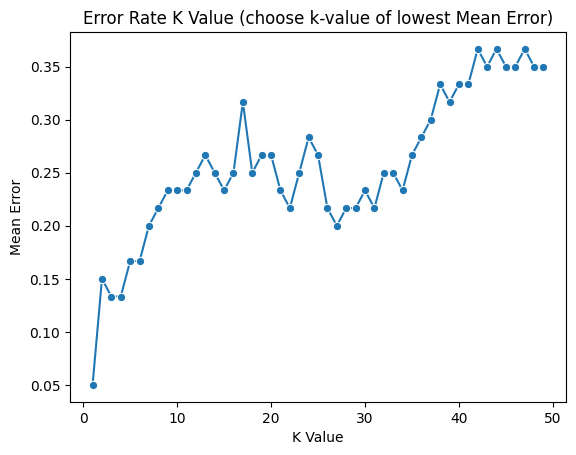

In [88]:
max_iterations = 50
# list to save the error values in the loop
error = []
# Calculating error for K values between 1 and 40
for i in range(1, max_iterations):

     # try with current k-value, train the model and make a test prediction
    knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=i))
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)

    # save the error value for this k-value
    error.append(np.mean(pred_i != y_test))
    
# plot all the k-values and their error values
sns.lineplot(x=range(1, max_iterations), y=error, marker='o')
plt.title('Error Rate K Value (choose k-value of lowest Mean Error)')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# choose best k-value based on metrics
# we have to add +1 to k-value, since argmin() returns an index
# which starts from 0, but k-values start from 1
print("Based on iterations, best k-value is this:")
k_value = np.argmin(error) + 1
print(k_value)



## Training

In [89]:
# build the model with the optimal values
model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k_value))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

## Metrics

In [90]:
# get predictions for error metrics
predictions = model.predict(X_test)
# print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=False)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)

# We have to use multiclass ROC AUC.
# List of classes
classes = sorted(y.unique())
# Binarize classes
y_test_bin = label_binarize(y_test, classes=classes)
# Get the probabilities
y_score = model.predict_proba(X_test)
# Fiunally, ROC AUC
# One VS Rest (ovr) is vulnerable to imbalance, that's why we are using weighted average to mitigate this problem
roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='weighted')

print(report)
print(f"Overall model accuracy: {acc*100}%")
print(f"ROC AUC score: {round(roc_auc,2)}")

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       1.00      1.00      1.00         7
           2       1.00      0.80      0.89         5
           3       0.71      1.00      0.83         5
           4       1.00      1.00      1.00        16

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.93        60
weighted avg       0.96      0.95      0.95        60

Overall model accuracy: 95.0%
ROC AUC score: 0.97


<AxesSubplot: >

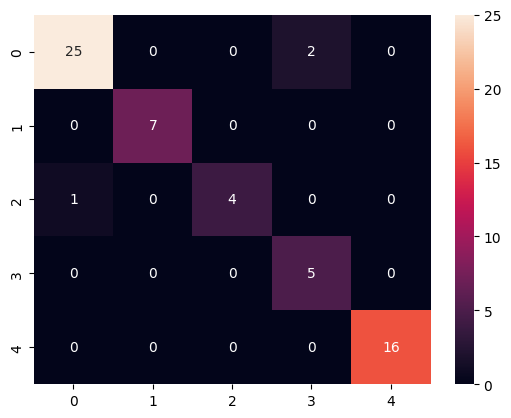

In [91]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

# Optimized Model

## Tuning

In [92]:
# We need to add prefix kneighborsclassifier__ in order to make it work with scikit pipeline.
# Without it, parameters would be passed not to KNeighborsClassifier(), but to piepline in general, which will raise error
param_grid = {
    'kneighborsclassifier__n_neighbors': [1],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    }

In [93]:
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                         'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski'],
                         'kneighborsclassifier__n_neighbors': [1],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             scoring='accuracy')

## Best parameters

In [94]:
# Save parameters to variable
best_params = grid_search.best_params_
# Strip prefix before passing them to estimator
best_params = {k.replace('kneighborsclassifier__', ''): v for k, v in best_params.items() if k.startswith('kneighborsclassifier__')}
# Print best parameters and score
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best Cross-Validation Score: 0.8285714285714285


## Training

In [95]:
best_model = make_pipeline(StandardScaler(), KNeighborsClassifier(**best_params))
best_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=1))])

## Metrics

In [96]:
# get predictions for error metrics
predictions = best_model.predict(X_test)
# print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=False)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)

# We have to use multiclass ROC AUC.
# List of classes
classes = sorted(y.unique())
# Binarize classes
y_test_bin = label_binarize(y_test, classes=classes)
# Get the probabilities
y_score = model.predict_proba(X_test)
# Fiunally, ROC AUC
# One VS Rest (ovr) is vulnerable to imbalance, that's why we are using weighted average to mitigate this problem
roc_auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='weighted')

print(report)
print(f"Overall model accuracy: {acc*100}%")
print(f"ROC AUC score: {round(roc_auc,2)}")

              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       1.00      1.00      1.00         7
           2       1.00      0.80      0.89         5
           3       0.71      1.00      0.83         5
           4       1.00      1.00      1.00        16

    accuracy                           0.95        60
   macro avg       0.94      0.95      0.93        60
weighted avg       0.96      0.95      0.95        60

Overall model accuracy: 95.0%
ROC AUC score: 0.97


<AxesSubplot: >

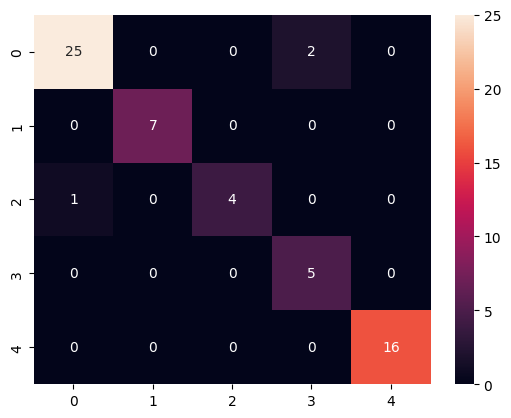

In [97]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

# Conclusion

The data set was pretty simple, only with 200 rows and only few features. KNN in this case showed itself pretty well, metrics were great with few errors only. There is a problem with class 0, I think because it is a majority class that differs from the others mainly by only one parameter (Na to K proportion). Otherwise in this case results look perfect. 

However, if random state of train test split is unlocked, because of the size of dataset, metrics might be very different. This problem with majority class can grow into bigger one, as I once got accuracy around 80% and a lot of class 1 and 2 classified as 0.

Optimization was kind of useless. In some cases (unlocked random state on train test split), there were very tiny differences, when model recognized some border rows as different classes. I guess for more complex data parameter tuning have bigger role. 

Also I afterwards thought, that I've should include best K-value search into hyper parameters tuning, because there might different best K-value for different distnace metrics or algorithms. This doesn't matter that much for this dataset, but I think in general it would be good practice. 